# Dectecting Heart Disease Machine Learning Project

This project uses data from the UCI Machine Learning Repository<br>
<br>
**Citation:**<br>
Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

### Imports

In [1]:
# Importing Libraries

# Custom Functions
from heart_ml_utils import *

# Data Exploration and Plotting
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Pipelining
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scoring
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [2]:
feat_names = ['age', # (numerical)
              'sex', # (binary)
              'cp', # (categorical) [1-4] chest pain 
              'trestbps', # (numerical) resting blood pressure 
              'chol', # (numerical) serum cholestoral in mg/dl 
              'fbs', # (binary) fasting blood sugar > 120 mg/dl 
              'restecg', # (ordinal)(pre-encoded) [0-2] resting electrocardiographic results 
              'thalach', # (numerical) maximum heart rate acheived 
              'exang', # (binary) exercised induced angina 
              'oldpeak', # (numerical) ST depression induced by exercise relative to rest 
              'slope', # (ordinal)(pre-encoded) [1-3] slope of the peak exercise ST segment
              'ca', # (numerical) number of major vessels colored by flourosopy
              'thal', # (ordinal)(pre-encoded) "3 = normal; 6 = fixed defect; 7 = reversable defect"
              'num'] # (categorical) [0-4] diagnosis 
heart_df = pd.read_csv('cleveland_heart_data', names = feat_names)

## Data Cleaning and Feature Engineering

In [3]:
# Replace ?s with None to be imputed later

cleaned_df = heart_df

cleaned_df = string_to_Na(cleaned_df, '?') #using custom function (see heart_ml_utils.py)

In [3]:
# ALTERNATIVELY: Drop observations with problematic values (see heart_ml_data_explor.ipynb)

cleaned_df = heart_df

# Create a dictionary of column-value pairs for flexible alteration
drop_dict = {'restecg':1,
             'ca':'?',
             'thal':'?'
}

# Drop data according to dictionary
for drop_col in list(drop_dict.keys()):
    cleaned_df = drop_data(cleaned_df, drop_col, drop_dict[drop_col]) #using custom function (see heart_ml_utils.py)   

print(f'dropped {round((heart_df.shape[0] - cleaned_df.shape[0])*100 / heart_df.shape[0],2)}% of data')

dropped 3.3% of data


In [4]:
# Now that the ?s have been dealt with the columns must be converted from object to float

# Create a dictionary of column-type pairs for flexible alteration
dtype_dict = {'ca':'float',
              'thal':'float'
}

# Convert columns into new data types according to dictionary
for col in list(dtype_dict.keys()):
    cleaned_df[col] = cleaned_df[col].astype(dtype_dict[col])

In [5]:
# Rather than predicting specific diseases, this model will classify between diseased and healthy

cleaned_df.loc[cleaned_df['num']>0, 'num'] = 1
# 0 means healthy, 1 means diseased

In [6]:
# OPTIONAL: Consider using a binary version of oldpeak

cleaned_df['st_no_change'] = 0
cleaned_df.loc[cleaned_df['oldpeak']>0, 'st_no_change'] = 1
cleaned_df.drop(columns='oldpeak', inplace=True)

## Data Splitting

In [6]:
# Separate predictor features (X) and target feature (y)

X = cleaned_df
y = X.pop('num')

In [7]:
# Seperate test data from training data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Preprocessing Pipeline

In [8]:
# Specify categorical features to be onehot encoded

onehot_features = ['cp']

In [10]:
# OPTIONAL: Identify ordinally pre-ecoded features to test onehot encoding instead

ordinal_to_onehot = ['restecg', 'slope', 'thal']
onehot_features += ordinal_to_onehot

In [46]:
# UNUSED: Create ordinal encoder
#(potentially useful when switching to the 76 feature dataset or reusing code in another project)

# Create dictionary of ordinal features and their ordered values
ordinal_codes_dict = {'feature':['ordered','list','of','values'],
                      'feature':['ordered','list','of','values']
}

# Get column indexes of ordinal features
ordinal_ids = X.columns.get_indexer(list(ordinal_codes_dict.keys()))

# Create list of ordered lists, ordered by feature index
ordinal_codes_list = []
for id in ordinal_ids:
    ordinal_codes_list.append(ordinal_codes_dict[X.columns[id]])

# Create tuple to be used for ordinal encoder in a column transformer
ordinal_transformer = ("cat_ordinal", 
                       OrdinalEncoder(categories=ordinal_codes_list), 
                       ordinal_ids)

In [9]:
# Create lists of categorical and numerical features for pipelining

cat_features = onehot_features #+ list(ordinal_codes_dict.keys())
num_features = list(set(X.columns)-set(cat_features))

In [10]:
# Create categorical encoder

cat_encoder = ColumnTransformer(transformers=[
    #ordinal_transformer,
    ("cat_onehot", 
     OneHotEncoder(drop='first'), 
     list_indexes(onehot_features,cat_features))
])

In [11]:
# Create categorical pipeline

cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                         cat_encoder)

In [12]:
# Create numerical pipeline

num_pipe = make_pipeline(SimpleImputer(strategy='mean')) #can be varied with hyperparameter tuning

In [13]:
# Create full preprocessor with categorical and numerical columns

preprocessor = ColumnTransformer(transformers=[
    ('num_pipe', num_pipe, num_features),
    ('cat_pipe', cat_pipe, cat_features)
])
preprocessor

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['age', 'trestbps', 'ca', 'exang', 'fbs',
                                  'oldpeak', 'thalach', 'chol', 'restecg',
                                  'thal', 'slope', 'sex']),
                                ('cat_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('columntransformer',
                                                  ColumnTransformer(transformers=[('cat_onehot',
                                                                                   OneHotEncoder(drop='first'),
                                                                                   [0])]))]),
                                 ['cp'])])

**Data choices and their results**
* Remove less data
    * Result: Little difference due to the small amount of data lost, however inputation was more successful
<br>
<br>
* Try binary version of oldpeak
    * Result: Numerical version was more successful
<br>
<br>
* Onehot encode features currently ordinally pre-encoded
    * Result: All models made better predictions with onehot encoding. However, when set to max recall, gardient boosting, logistic regression, and the support vector machine all suffered (~0.04 drop in accuracy)

## Modelling

### Logistic Regression

In [25]:
# Create and tune logistic regression

# Complete pipeline with scaler
lr_pipeline = make_pipeline(preprocessor,
                            RobustScaler(),
                            LogisticRegression()) #sklearn logistic regression automatically regularizes

# Define parameter grid to test hyperparameters during tuning
lr_param_grid = {
    #'robustscaler':[RobustScaler(), StandardScaler(), MinMaxScaler()],
    #'columntransformer__num_pipe__simpleimputer__strategy': ['mean', 'median'],
    "logisticregression__penalty": ['l2', 'l1', 'elasticnet'], 
    "logisticregression__C": np.arange(0.15, 0.28, 0.01),
    "logisticregression__solver": ['lbfgs', 'liblinear', 'saga', 'newton-cholesky'] #dont use newton-cholesky with large-feature dataset!
} #only certain combinations of solvers and penalties will work (many failures is okay!)

# Execute 5 fold cross validation for hyperparameter tuning
lr_search = GridSearchCV(lr_pipeline,
                         lr_param_grid,
                         scoring='accuracy',#'recall',
                         cv=5)
lr_search.fit(X_train, y_train)

c:\Users\rockw\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
420 fits failed out of a total of 840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rockw\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rockw\anaconda3\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\rockw\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         ['age',
                                                                          'trestbps',
                                                                          'ca',
                                                                          'exang',
                                                                          'fbs',
                                                                          'oldpeak',
                                                                          'thalach',
                                                                          'chol',
                                                                          'restecg',
                                                                          'thal',
                                                                          'slope',
                                                                          'sex']),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('colu...
                                                                         ['cp'])])),
                                       ('robustscaler', RobustScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': array([0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25,
       0.26, 0.27, 0.28]),
                         'logisticregression__penalty': ['l2', 'l1',
                                                         'elasticnet'],
                         'logisticregression__solver': ['lbfgs', 'liblinear',
                                                        'saga',
                                                        'newton-cholesky']},
             scoring='accuracy')

#### Check hyperparameters and scores

In [16]:
# Check optimal hyperparameters

lr_search.best_params_
# mean and robust scaler

{'logisticregression__C': 0.24000000000000007,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'lbfgs'}

In [23]:
# Display training data results

lr_results = get_scores(lr_search, X_train, y_train, name='SVM')
lr_results

,Accuracy,Precision,Recall,F1,AUC
SVM,0.863436,0.89011,0.794118,0.839378,0.928863


### Support Vector Machine

In [26]:
# Create and tune support vector machine

# Complete pipeline with scaler
svc_pipeline = make_pipeline(preprocessor,
                             RobustScaler(),
                             SVC(probability=True))

# Define parameter grid to test hyperparameters during tuning
svc_param_grid = {
    #'robustscaler': [RobustScaler(), StandardScaler(), MinMaxScaler()],
    'columntransformer__num_pipe__simpleimputer__strategy': ['mean', 'median'],
    "svc__kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "svc__C": np.arange(0.4,0.6,0.01)
}

# Execute 5 fold cross validation for hyperparameter tuning
svc_search = GridSearchCV(svc_pipeline,
                          svc_param_grid,
                          scoring='accuracy',#'recall',
                          cv=5)
svc_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         ['age',
                                                                          'trestbps',
                                                                          'ca',
                                                                          'exang',
                                                                          'fbs',
                                                                          'oldpeak',
                                                                          'thalach',
                                                                          'chol',
                                                                          'restecg',
                                                                          'thal',
                                                                          'slope',
                                                                          'sex']),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('colu...
                                                                                                                           [0])]))]),
                                                                         ['cp'])])),
                                       ('robustscaler', RobustScaler()),
                                       ('svc', SVC(probability=True))]),
             param_grid={'columntransformer__num_pipe__simpleimputer__strategy': ['mean',
                                                                                  'median'],
                         'svc__C': array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ,
       0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59]),
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

#### Check hyperparameters and scores

In [19]:
# Check optimal hyperparameters

svc_search.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'svc__C': 0.4700000000000001,
 'svc__kernel': 'sigmoid'}

In [16]:
# Display training data results

svc_results = get_scores(svc_search, X_train, y_train, name='SVM')
svc_results

,Accuracy,Precision,Recall,F1
SVM,0.859504,0.901099,0.766355,0.828283


### Random Forest

In [27]:
# Create and tune random forest classifier

# Complete pipeline
rf_pipeline = make_pipeline(preprocessor,
                            RandomForestClassifier())

# Define parameter grid to test hyperparameters during tuning
rf_param_grid = {
    'columntransformer__num_pipe__simpleimputer__strategy': ['mean'],
    'randomforestclassifier__n_estimators': range(50, 120, 10),
    'randomforestclassifier__max_depth': range(1, 4, 1),
    'randomforestclassifier__criterion': ['entropy'], #['gini', 'entropy'],
    'randomforestclassifier__bootstrap': [True],
    'randomforestclassifier__oob_score': [False], #[True, False],
    'randomforestclassifier__max_features': ['sqrt', 'log2']
}

# Execute 5 fold cross validation for hyperparameter tuning
rf_search = GridSearchCV(rf_pipeline,
                         rf_param_grid,
                         scoring='accuracy',#'recall',
                         cv=5)
rf_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         ['age',
                                                                          'trestbps',
                                                                          'ca',
                                                                          'exang',
                                                                          'fbs',
                                                                          'oldpeak',
                                                                          'thalach',
                                                                          'chol',
                                                                          'restecg',
                                                                          'thal',
                                                                          'slope',
                                                                          'sex']),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('colu...
             param_grid={'columntransformer__num_pipe__simpleimputer__strategy': ['mean'],
                         'randomforestclassifier__bootstrap': [True],
                         'randomforestclassifier__criterion': ['entropy'],
                         'randomforestclassifier__max_depth': range(1, 4),
                         'randomforestclassifier__max_features': ['sqrt',
                                                                  'log2'],
                         'randomforestclassifier__n_estimators': range(50, 120, 10),
                         'randomforestclassifier__oob_score': [False]},
             scoring='accuracy')

#### Check hyperparameters and scores

In [25]:
# Check optimal hyperparameters

rf_search.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 1,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__n_estimators': 90,
 'randomforestclassifier__oob_score': False}

In [34]:
# Display training data results

rf_results = get_scores(rf_search, X_train, y_train, name='Random Forest')
rf_results

,Accuracy,Precision,Recall,F1
Random Forest,0.859504,0.929412,0.738318,0.822917


### Gradient Boosting

In [28]:
# Create and tune gradient boosting classifier

# Complete pipeline
gb_pipeline = make_pipeline(preprocessor,
                            GradientBoostingClassifier())

# Define parameter grid to test hyperparameters during tuning
gb_param_grid = {
    'columntransformer__num_pipe__simpleimputer__strategy':['mean'],
    'gradientboostingclassifier__n_estimators': range(80, 120, 10),
    'gradientboostingclassifier__max_depth': range(1, 4, 1),
    'gradientboostingclassifier__learning_rate': np.arange(0.09, 0.15, 0.01),
    'gradientboostingclassifier__criterion': ['friedman_mse'], #['friedman_mse', 'squared_error'],
    'gradientboostingclassifier__max_features': ['sqrt', 'log2']
}

# Execute 5 fold cross validation for hyperparameter tuning
gb_search = GridSearchCV(gb_pipeline,
                         gb_param_grid,
                         scoring='accuracy',#'recall',
                         cv=5)
gb_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         ['age',
                                                                          'trestbps',
                                                                          'ca',
                                                                          'exang',
                                                                          'fbs',
                                                                          'oldpeak',
                                                                          'thalach',
                                                                          'chol',
                                                                          'restecg',
                                                                          'thal',
                                                                          'slope',
                                                                          'sex']),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('colu...
             param_grid={'columntransformer__num_pipe__simpleimputer__strategy': ['mean'],
                         'gradientboostingclassifier__criterion': ['friedman_mse'],
                         'gradientboostingclassifier__learning_rate': array([0.09, 0.1 , 0.11, 0.12, 0.13, 0.14]),
                         'gradientboostingclassifier__max_depth': range(1, 4),
                         'gradientboostingclassifier__max_features': ['sqrt',
                                                                      'log2'],
                         'gradientboostingclassifier__n_estimators': range(80, 120, 10)},
             scoring='accuracy')

#### Check hyperparameters and scores

In [27]:
# Check optimal hyperparameters

gb_search.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'gradientboostingclassifier__criterion': 'friedman_mse',
 'gradientboostingclassifier__learning_rate': 0.09,
 'gradientboostingclassifier__max_depth': 3,
 'gradientboostingclassifier__max_features': 'log2',
 'gradientboostingclassifier__n_estimators': 100}

In [28]:
# Display training data results

gb_results = get_scores(gb_search, X_train, y_train, name='Gradient Boosting')
gb_results

,Accuracy,Precision,Recall,F1,AUC
Gradient Boosting,0.982379,0.99,0.970588,0.980198,0.997333


#### Combat overfitting with an early stop

In [20]:
# Combat overfitting with an early stop

early_stop_clf = GradientBoostingClassifier(
    criterion=gb_search.best_params_['gradientboostingclassifier__criterion'],
    learning_rate=gb_search.best_params_['gradientboostingclassifier__learning_rate'],
    max_depth=gb_search.best_params_['gradientboostingclassifier__max_depth'],
    max_features=gb_search.best_params_['gradientboostingclassifier__max_features'],
    n_estimators=gb_search.best_params_['gradientboostingclassifier__n_estimators'],
    n_iter_no_change=5,
    tol=0.0001                                       
)

gb_early_stop = make_pipeline(preprocessor,
                              early_stop_clf)

gb_early_stop.fit(X_train, y_train)
gb_early_results = get_scores(gb_early_stop, X_train, y_train, name='Gradient Boosting Early Stop')
gb_early_results

,Accuracy,Precision,Recall,F1,AUC
Gradient Boosting Early Stop,0.92511,0.947368,0.882353,0.913706,0.978588


## Scoring and Plotting

In [34]:
# Define dictionary with name-model pairs

models_dict = {'Logistic Regression':lr_search,
               'Support Vector Machine':svc_search,
               'Random Forest':rf_search,
               'Gradient Boosting':gb_search,
               'Gradient Boosting Early Stop':gb_early_stop
}

**Note on Thresholds and Recall**<br>
Because we are checking for a disease, it is important to minimize false negatives even at the cost of lower accuracy. A false positive leads to more tests which can correct for the error, but a false negative puts someone in danger by not getting them the help they need. When making predictions with the model, we have the option to change the threshold of certainty such that if the model thinks it is somewhat likely that the person is diseased, even if it is more likely that they aren't, the model will still return positive just to be safe. In the following custom functions the parameter "thresh" will allow for the setting of this threshold. Anything below 0.5 will decrease accuracy while increasing recall. For functions with the parameter "safe", setting this to True will score with model predictions that have adjusted this threshold such that it will return no false negatives with the training data.

In [36]:
# Score and compare models with test data

# Custom function compares safe (max recall) versions and best prediction version of all models. Optionally a manually set threshold can also be added
best_vs_safe(models_dict, 
             X=X_test, y=y_test,                    #CHOICE: test or training data
             X_train=X_train, y_train=y_train)      #CHOICE: optionally add manual threshold value (thresh=__) 

,Accuracy,Precision,Recall,F1,AUC
Gradient Boosting,0.828947,0.833333,0.810811,0.821918,0.916147
Gradient Boosting (max recall),0.723684,0.637931,1.000000,0.778947,0.916147
Gradient Boosting Early Stop,0.855263,0.842105,0.864865,0.853333,0.931739
Gradient Boosting Early Stop (max recall),0.526316,0.506849,1.000000,0.672727,0.931739
Logistic Regression,0.842105,0.837838,0.837838,0.837838,0.912682
Logistic Regression (max recall),0.605263,0.552239,1.000000,0.711538,0.912682
Random Forest,0.842105,0.878788,0.783784,0.828571,0.940402
Random Forest (max recall),0.592105,0.544118,1.000000,0.704762,0.940402
Support Vector Machine,0.881579,0.911765,0.837838,0.873239,0.934858
Support Vector Machine (max recall),0.592105,0.544118,1.000000,0.704762,0.934858


In [37]:
# Score and compare models (subset compared to function above)

score_models(models_dict, 
             X_test, y_test,    #CHOICE: test or training data
             safe=True,         #CHOICE: safest (max recall on testing data) or best prediction
             X_train=X_train, y_train=y_train)

,Accuracy,Precision,Recall,F1,AUC
Logistic Regression (max recall),0.605263,0.552239,1.0,0.711538,0.912682
Support Vector Machine (max recall),0.592105,0.544118,1.0,0.704762,0.934858
Random Forest (max recall),0.592105,0.544118,1.0,0.704762,0.940402
Gradient Boosting (max recall),0.723684,0.637931,1.0,0.778947,0.916147
Gradient Boosting Early Stop (max recall),0.526316,0.506849,1.0,0.672727,0.931739


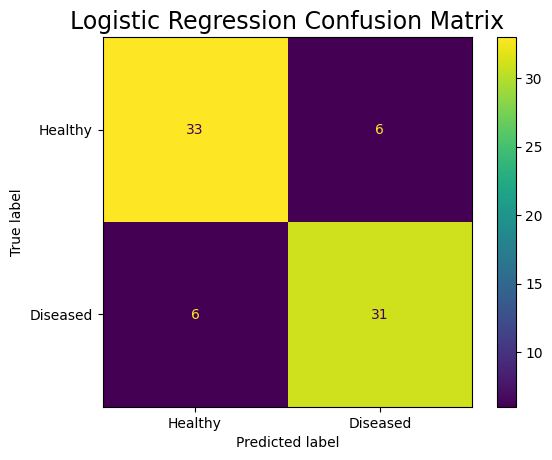

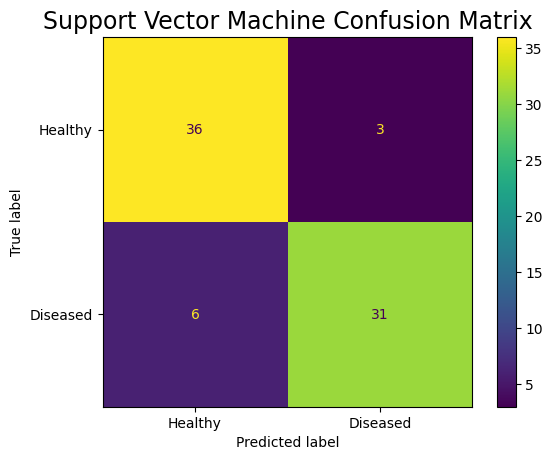

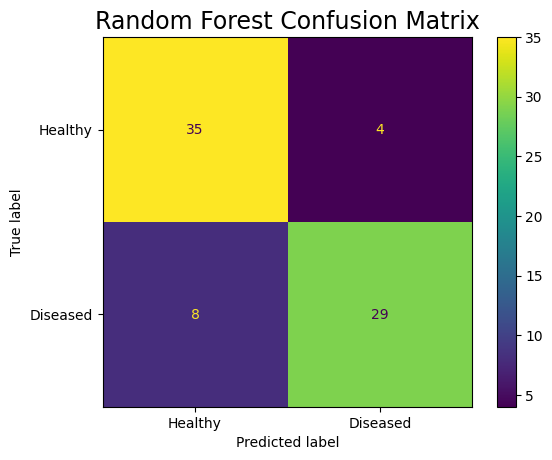

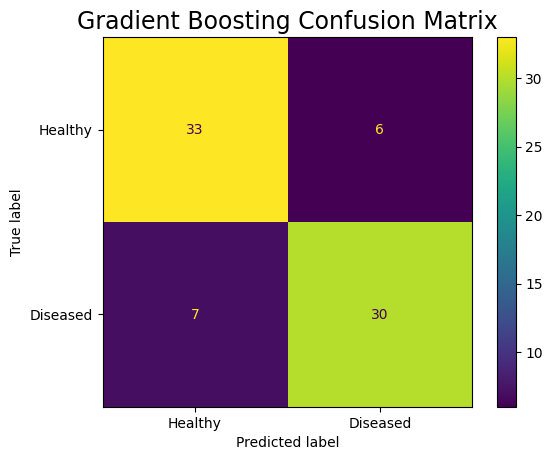

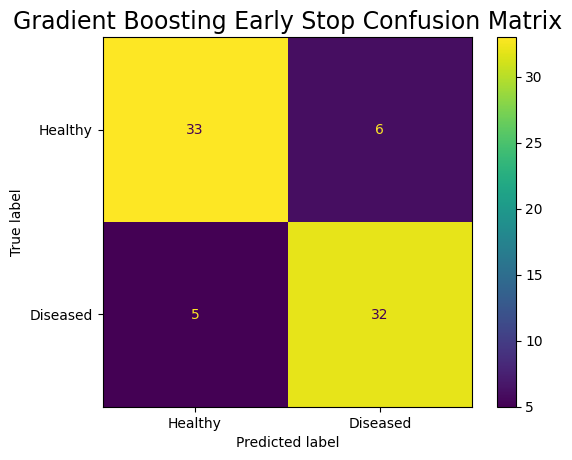

In [38]:
# Plot confusion matricies for each model

for model in list(models_dict.keys()):
    plot_confusion(models_dict[model], name=model,
    X= X_test, y = y_test,      #CHOICE: test or training data
    safe=False,                 #CHOICE: safest (max recall on testing data) or best prediction
    X_train=X_train, y_train=y_train)

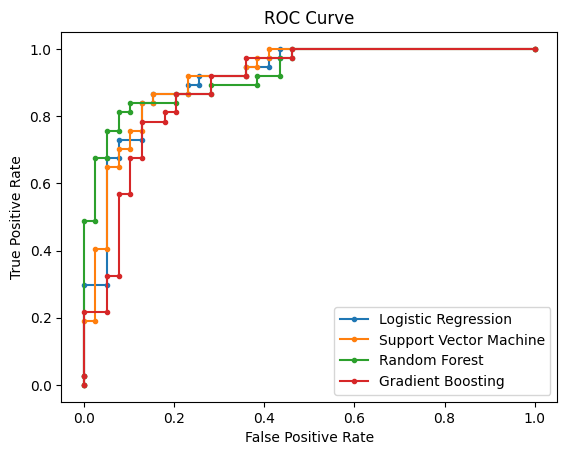

In [25]:
# Plot ROC curves for models using dictionary

plot_roc(models_dict, X_test, y_test)

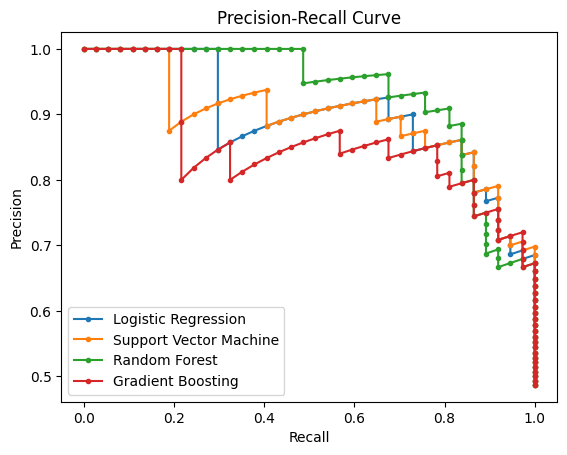

In [26]:
# Plot precision-recall curves for models using dictionary

plot_pr(models_dict, X_test, y_test)

**Data choices to try adjusting when testing the models**
* Remove less data
    * Result: Inputation was more successful
<br>
<br>
* Try binary version of oldpeak
    * Result: Numerical version was more successful
<br>
<br>
* Onehot encode features currently ordinally pre-encoded
    * Result: All models made better predictions. However, when set to max recall, gardient boosting, logistic regression, and the support vector machine all suffered (~0.04 drop in accuracy)

## Stacked Modelling
Adding each model's predictions as an additional predictor feature for a second generation of models to train on

In [29]:
# Add each model's predictions as predictor features

# Define dictionary with name-model-pipeline pairs
models_pipes_dict = {'Logistic Regression':[lr_search,lr_pipeline],
                     'Support Vector Machine':[svc_search,svc_pipeline],
                     'Random Forest':[rf_search,rf_pipeline],
                     'Gradient Boosting':[gb_search,gb_pipeline]#,
                     #'Gradient Boosting Early Stop':[gb_early_stop,gb_pipeline]
}

# Initialize new predictor data frames
X_train_stacked = X_train
X_test_stacked = X_test

# Add new predictor features with probabilities predicted by each model
for model in list(models_pipes_dict.keys()):
    X_train_stacked[model]=models_pipes_dict[model][0].predict_proba(X_train)[:,1]
    X_test_stacked[model]=models_pipes_dict[model][0].predict_proba(X_test)[:,1]

In [30]:
# Tune each model to stacked predictors and add to new dictionary

stacked_models_dict={}

for model in list(models_pipes_dict.keys()):
    model_name =  'Stacked ' + model
    stacked_model = duplicate_model(pipe=models_pipes_dict[model][1], model=models_pipes_dict[model][0])
    stacked_model.fit(X_train_stacked, y_train)
    stacked_models_dict[model_name] = stacked_model

c:\Users\rockw\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
420 fits failed out of a total of 840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rockw\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rockw\anaconda3\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\rockw\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty

In [31]:
# Score stacked models

models_dict = {key: value[0] for key, value in models_pipes_dict.items()}

stacked_scores = best_vs_safe(stacked_models_dict, 
                              X=X_test_stacked, 
                              y=y_test,    
                              X_train=X_train_stacked, 
                              y_train=y_train)
normal_scores = best_vs_safe(models_dict, 
                             X=X_test, 
                             y=y_test,    
                             X_train=X_train, 
                             y_train=y_train)
all_scores = pd.concat([stacked_scores,normal_scores]).sort_values('Accuracy', ascending=False)
all_scores

,Accuracy,Precision,Recall,F1,AUC
Gradient Boosting,0.868421,0.864865,0.864865,0.864865,0.925502
Random Forest,0.868421,0.909091,0.810811,0.857143,0.942481
Stacked Gradient Boosting,0.855263,0.861111,0.837838,0.849315,0.911296
Stacked Random Forest,0.842105,0.857143,0.810811,0.833333,0.939709
Stacked Support Vector Machine,0.842105,0.820513,0.864865,0.842105,0.912682
Logistic Regression,0.842105,0.837838,0.837838,0.837838,0.912682
Support Vector Machine,0.828947,0.800000,0.864865,0.831169,0.914068
Stacked Logistic Regression,0.815789,0.780488,0.864865,0.820513,0.903673
Stacked Gradient Boosting (max recall),0.736842,0.649123,1.000000,0.787234,0.911296
Gradient Boosting (max recall),0.671053,0.596774,1.000000,0.747475,0.925502


**Results** <br>
The Stacked Gradient Boosting model has the best accuracy of the models with perfect recall (73.68%) <br>
The Gradient Boosting model has the best F1 score <br>
The Random Forest model has the best AUC <br>

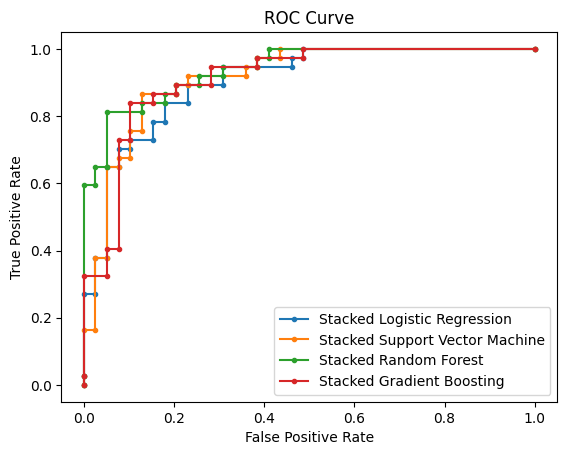

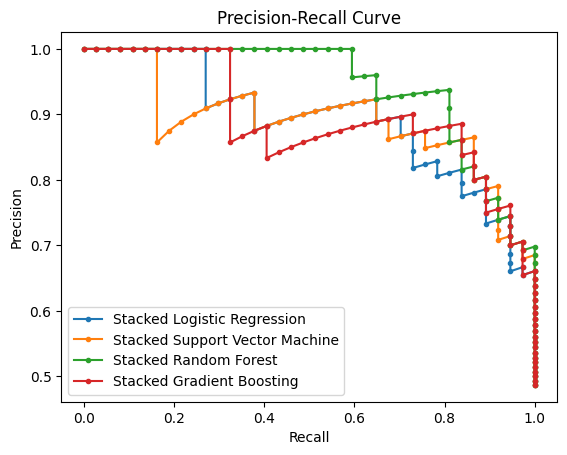

In [32]:
# Plot ROC curves for models using dictionary

plot_roc(stacked_models_dict, X_test_stacked, y_test)
# Plot precision-recall curves for models using dictionary

plot_pr(stacked_models_dict, X_test_stacked, y_test)